# Задание 4 - Перенос обучения (transfer learning) и тонкая настройка (fine-tuning)

Одной из важнейшних техник в тренировке сетей - использовать заранее натренированные веса на более общей задачи в качестве начальной точки, а потом "дотренировать" их на конкретной.

Такой подход и убыстряет обучение, и позволяет тренировать эффективные модели на маленьких наборах данных.

В этом упражнении мы натренируем классификатор, который отличает хотдоги от не хотдогов!  
(более подробно - https://www.youtube.com/watch?v=ACmydtFDTGs)

Это задание требует доступа к GPU, поэтому его можно выполнять либо на компьютере с GPU от NVidia, либо в [Google Colab](https://colab.research.google.com/).

In [ ]:
!pip install -q torch torchvision
!pip install -q Pillow
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install pytorch-lightning
#!pip install efficientnet_pytorch
!pip install opencv-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-l94flkz8
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-l94flkz8
^C
ERROR: Operation cancelled by user


In [ ]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image


import cv2

from socket import timeout

import re
from skimage import io, transform

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import pytorch_lightning as pl


In [ ]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline

from torch.utils.data.sampler import Sampler
import torch.nn.functional as F
import sklearn.metrics as metrics


import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, MultiStepLR

import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device("cuda:0") # Let's make sure GPU is available!
#torch.set_default_tensor_type(torch.HalfTensor)

In [ ]:
def seed_everything(seed):
    #random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

Сначала давайте скачаем данные с картинками. Это сделает код в следующей ячейке. Данные будут разделены на две части. На обучающей выборке, которая будет храниться в папке **train_kaggle**, мы будем строить наши модели, а на тестовой выборке **test_kaggle** будем предсказывать класс, к которому относится фотография (хотдог или нет).

### Если вы в Google Colab!

В нем можно запускать ноутбуки с доступом к GPU. Они не очень быстрые, зато бесплатные!
Каждый ноутбук получает свой собственный environment c доступным диском итд.

Через 90 минут отсуствия активности этот environment пропадает со всеми данными.
Поэтому нам придется скачивать данные каждый раз.

In [ ]:
# Download train data
!wget -nc "https://nadyashare.s3.eu-central-1.amazonaws.com/small_test.csv"

# Download train data
!wget -nc "https://nadyashare.s3.eu-central-1.amazonaws.com/bigImages.zip"

!wget -nc "https://nadyashare.s3.eu-central-1.amazonaws.com/Train_fixed.csv"


--2020-10-04 20:09:13--  https://nadyashare.s3.eu-central-1.amazonaws.com/middle_rn34_wt.csv
Resolving nadyashare.s3.eu-central-1.amazonaws.com (nadyashare.s3.eu-central-1.amazonaws.com)... 52.219.72.9
Connecting to nadyashare.s3.eu-central-1.amazonaws.com (nadyashare.s3.eu-central-1.amazonaws.com)|52.219.72.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198927 (194K) [text/csv]
Saving to: ‘middle_rn34_wt.csv’

middle_rn34_wt.csv  100%[===================>] 194.26K  --.-KB/s    in 0.005s  

2020-10-04 20:09:13 (37.2 MB/s) - ‘middle_rn34_wt.csv’ saved [198927/198927]

File ‘bigImages.zip’ already there; not retrieving.

File ‘Train_fixed.csv’ already there; not retrieving.



# Имплементируем свой Dataset для загрузки данных

В этом задании мы реализуем свой собственный класс Dataset для загрузки данных. Его цель - загрузить данные с диска и выдать по ним тензор с входом сети, меткой и идентификатором картинки (так будет проще подготовить сабмит для kaggle на тестовых данных).

Вот ссылка, где хорошо объясняется как это делать на примере: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Ваш Dataset должен в качестве количества сэмплов выдать количество файлов в папке и уметь выдавать кортеж из сэмпла, метки по индексу и названия файла.
Если название файла начинается со слов 'frankfurter', 'chili-dog' или 'hotdog' - метка положительная. Иначе отрицательная (ноль).

И не забудьте поддержать возможность трансформации входа (аргумент `transforms`), она нам понадобится!

In [ ]:
df = pd.read_csv("small_test.csv")
#df["img_name"] = df["UID"].apply(lambda x: ".".join([x, "jpeg"]))
df.head()

,UID,growth_stage,img_name
0,01B4CV3K,2.0,01B4CV3K.jpeg
1,02XgtYwT,7.0,02XgtYwT.jpeg
2,04Opjmbk,3.0,04Opjmbk.jpeg
3,09YsAGWz,7.0,09YsAGWz.jpeg
4,0ANwTkIe,4.0,0ANwTkIe.jpeg


In [ ]:
full_df = pd.read_csv("Train_fixed.csv")
#full_df["img_name"] = val_df["UID"].apply(lambda x: ".".join([x, "jpeg"]))
full_df.head()

,UID,growth_stage,label_quality,img_name
0,nwuCTQKz,4,2,nwuCTQKz.jpeg
1,NVGUOzWu,1,1,NVGUOzWu.jpeg
2,1IYVvHwA,1,1,1IYVvHwA.jpeg
3,8OEdWwmU,1,1,8OEdWwmU.jpeg
4,oc5iO04j,1,1,oc5iO04j.jpeg


In [ ]:
!rm -rf bigImages
!rm -rf small_test
!unzip -qn "bigImages.zip"
ld = os.listdir("bigImages")
!mkdir bigImages/train
!mkdir bigImages/test
!mkdir small_test

folder = "bigImages"

for i in ld:
    #print(i)
    img_path = os.path.join(folder, i)
    if df[df["img_name"] == i].shape[0] > 0:
      os.link(img_path, os.path.join(os.getcwd(), "bigImages/train", i))
    if full_df[full_df["img_name"] == i].shape[0] == 0:
      os.link(img_path, os.path.join(os.getcwd(), "bigImages/test", i)) # картинки для предсказаний
      


In [ ]:
folder = "bigImages"
train_folder = "bigImages/train" 
#test_folder = "bigImages/train"
test_folder = "bigImages/test"
# Count number of files in the test folder, should be 3558

print('Number of files in the test folder', len(os.listdir(test_folder)))
big_test_folder = "bigImages/train"
print('Number of files in the train folder', len(os.listdir(train_folder)))

Number of files in the test folder 3558
Number of files in the train folder 6154


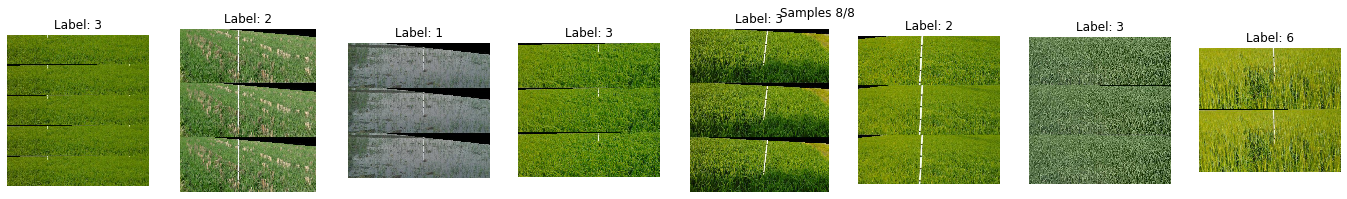

In [ ]:
import torchvision.transforms as tvtf

class WheatDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder = folder
        
        # TODO: Your code here!
        
    def __len__(self):
        return len(os.listdir(self.folder))
    
    def __getitem__(self, index):        
        # TODO Implement getting item by index
        # Hint: os.path.join is helpful!
        #print(index)
        img_name = os.listdir(self.folder)[index]
        img_path = os.path.join(self.folder, img_name)
        
        # Read an image with OpenCV
        image = cv2.imread(img_path)
        #print(img_name)
        try:
          y = df[df["img_name"] == img_name].loc[:,"growth_stage"].iloc[0] - 1
        except:
          y = -1
        if y == -1:
          try:
            y = full_df[full_df["img_name"] == img_name].loc[:,"growth_stage"].iloc[0] - 1
          except:
            y = -1
        #print(y)
        #plt.imshow(image)
        y = int(y)
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:

            augmented = self.transform(image=image)
            image = augmented['image']

        #imagePIL = tvtf.ToPILImage()(image)
        return image, y, img_name
    
def visualize_samples(dataset, indices, title=None, count=10, labels=None):
    # visualize random 10 samples
    fig1 = plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        fig1.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        ax = fig1.add_subplot(1,count,i+1)
        if labels:
          ax.set_title(labels[i])  
        else:
          ax.set_title("Label: %s" % y)
        ax.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = WheatDataset(train_folder)

indices = np.random.choice(np.arange(len(orig_dataset)), 8, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

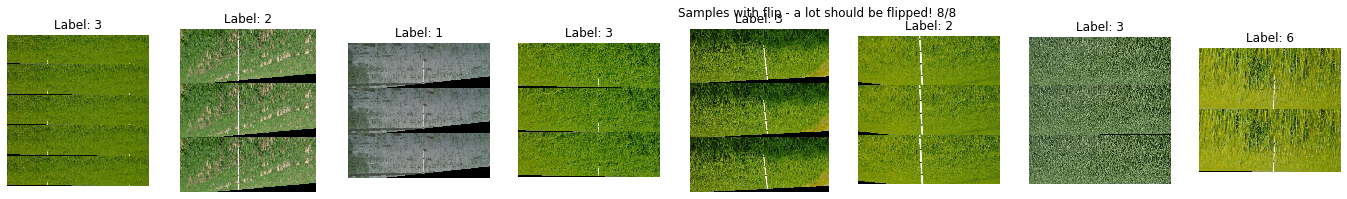

In [ ]:
# Let's make sure transforms work!
dataset = WheatDataset(train_folder, transform=A.VerticalFlip(0.9))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

dataset = WheatDataset(test_folder, transform=A.HorizontalFlip(0.9))

#visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

# Использование заранее натренированной сети (pretrained network)

Чаще всего в качестве заранее натренированной сети используется сеть, натренированная на данных ImageNet с 1M изображений и 1000 классами.

PyTorch включает такие натренированные сети для различных архитектур (https://pytorch.org/docs/stable/torchvision/models.html)  
Мы будем использовать ResNet18.

Для начала посмотрим, что выдает уже натренированная сеть на наших картинках. То есть, посмотрим к какому из 1000 классов их отнесет сеть.

Запустите модель на 10 случайных картинках из датасета и выведите их вместе с классами с наибольшей вероятностью.  
В коде уже есть код, который формирует соответствие между индексами в выходном векторе и классами ImageNet.

# Перенос обучения (transfer learning) - разные скорости обучения для разных слоев

И наконец последний вариант, который мы рассмотрим - использовать разные скорости обучения для новых и старых слоев

## Объявление модели

In [ ]:
import torchvision.models as models
from pytorch_lightning.core.lightning import LightningModule
from sklearn.model_selection import train_test_split
from pytorch_lightning.metrics.regression import RMSE
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning.metrics
import pytorch_lightning.metrics.functional as plf
from sklearn.metrics import confusion_matrix
#from efficientnet_pytorch import EfficientNet

pre_model = models.resnet34( pretrained=True)
image_size = 224


class TL_Wheat(LightningModule):
    def __init__(self, batch_size, df, image_size):
        super().__init__()
        # init a pretrained EfficientNet
        self.feature_extractor = pre_model

        #num_ftrs = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Linear(512, 1)

        # num_ftrs = self.feature_extractor._fc.in_features
        # self.feature_extractor._fc = nn.Linear(num_ftrs, num_target_classes)

        # for name, param in self.feature_extractor.named_parameters():
        #   print(name, param.requires_grad,  param.size())

        try:
          self.batch_size = int(batch_size)
          self.image_size = image_size
          print("image size", self.image_size)
          self.df = df
        except:
          self.batch_size = 128
          self.df = batch_size["df"]
          self.image_size = batch_size["image_size"]

        self.example_input_array = torch.zeros([128,3,224,224])
        self.pred=[]
        self.target = []

        for name, param in self.feature_extractor.named_parameters():
          if name.split(".")[-2] in ["bn3", "bn1", "bn2"]:
            param.requires_grad = False
          else:
             param.requires_grad = True
          #print(name, param.requires_grad, param.size())

    def forward(self, x):
        y = self.feature_extractor(x)
        return y
    
    def configure_optimizers(self):
        optimizer = optim.Adam(params = self.feature_extractor.parameters())
        return optimizer
           

    def training_step(self, batch, batch_idx):
        x = batch[0].to(dtype=torch.float32)
        y = batch[1].to(dtype=torch.float32).resize(batch[1].size(0), 1)
        #print(x.dtype, y.dtype)
        y_hat = self.forward(x)
        #lossfn = nn.CrossEntropyLoss(weight=self.weight)
        lossfn=nn.MSELoss()
        loss = lossfn(y_hat, y)

        result = pl.TrainResult(minimize=loss)
        result.log('train_loss', loss)
        #print(result)
        self.logger.experiment.add_scalar("Loss / Train", loss, self.current_epoch)
        return result

    def training_epoch_end(self, train_step_outputs):
      loss = torch.mean(train_step_outputs['train_loss'])
      result = pl.TrainResult(checkpoint_on=loss)
      result.log("Epoch", self.current_epoch, 'train_epoch_loss', loss)
      print(result)
      return result

    def RMSE(self, pred, y):
      sq = (pred - y) ** 2
      rmse = np.sqrt(np.sum(sq.cpu().detach().numpy(), axis=0)/y.size()[0]) 
      return torch.tensor(rmse)

    def validation_step(self, batch, batch_idx):
        x = batch[0].to(dtype=torch.float32)
        y = batch[1].to(dtype=torch.float32).resize(batch[1].size(0), 1)
        #print(x.dtype, y.dtype)
        y_hat = self.forward(x)
        #print(y.size(), y_hat.size(), y, y_hat)
        #_, indices = torch.max(y_hat, 1)
        self.pred.extend(np.round(y_hat.cpu().detach().numpy()))
        self.target.extend(y.cpu().detach().numpy())
        #loss = RMSE()(indices.to(dtype=float), y.to(dtype=float))
        loss = RMSE()(y_hat.to(dtype=float), y.to(dtype=float))
        result = pl.EvalResult()
        result.log('step_val_loss', loss)
        #print(result)
        return result
      
    def validation_epoch_end(self, val_step_outputs):
      #print(val_step_outputs["step_val_loss"])
      # do something with the outputs of all val batches
      loss = torch.mean(val_step_outputs["step_val_loss"])
      result = pl.EvalResult(checkpoint_on=loss)
      #result.log('final_metric', loss)
      result.log('val_loss', loss)
      print(result)
      #print(self.pred, self.target)
      conf_mat = confusion_matrix(self.target, self.pred)
      print(conf_mat)
      #print(plf.stat_scores_multiple_classes(self.pred, self.target))
      #fig = plt.figure()
      #plt.imshow(conf_mat)
      #plt.show()
      self.pred=[]
      self.target = []
      return result


    def prepare_data(self):
      self.train_dataset = WheatDataset(train_folder, 
                       transform=A.Compose([
                          A.CLAHE(p=1),
                          #A.SmallestMaxSize(224),

                             A.OneOf([
                                A.HorizontalFlip(),
                                A.Rotate(limit=45), 
                            ]),

                            A.OneOf([
                              A.RandomBrightnessContrast(),
                              A.HueSaturationValue(),
                              A.RGBShift()
                            ]),

                            A.OneOf([
                              A.Blur(),
                              A.RandomGamma(),
                             A.MultiplicativeNoise()
                           ],p=0),

                           A.CoarseDropout(p=0.8),

                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                          #A.RandomCrop(224, 224, p = 1),
                          A.RandomCrop(self.image_size, self.image_size, p = 1),
                          A.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),   
                          ToTensorV2(),
                       ])
                                   
                      )
      self.val_dataset = WheatDataset(train_folder, 
                       transform=A.Compose([
                          A.CLAHE(p=1),
                          A.RandomCrop(self.image_size, self.image_size, p = 1),
                          #A.RandomCrop(224, 224, p = 1),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           A.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) ,  
                           ToTensorV2(),                        
                       ])
                      )
      self.test_dataset = WheatDataset(test_folder, 
                       transform=A.Compose([
                          A.CLAHE(p=1),
                          A.OneOf([
                                A.HorizontalFlip(),
                                A.Rotate(limit=45), 
                            ]),
                          A.RandomCrop(self.image_size, self.image_size, p = 1),
                          A.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) ,  
                           ToTensorV2(),                       
                       ])
                       )
      self.predict_dataset = WheatDataset(big_test_folder, 
                       transform=A.Compose([
                          A.CLAHE(p=1),
                          A.RandomCrop(self.image_size, self.image_size, p = 1),
                          A.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) ,  
                           ToTensorV2(),                       
                       ])
                       )
      
      validation_fraction = .2
      train_indices = []
      val_indices = []
      y_labels = []
      self.df["gs"] = round(self.df["growth_stage"])
      for g in self.df.groupby("gs"):

        #print(g[0])
        X_train, X_test, y_train, y_test = train_test_split(g[1].index, g[1].loc[:,"growth_stage"], 
                                                          test_size=validation_fraction, random_state=42)
        
        #балансирую классы
        if g[0] == 1:
          #print(y_train)
          X_train = np.repeat(X_train, 5)
          y_train = np.repeat(y_train, 5)
          
        if g[0] == 5:
          X_train = np.repeat(X_train, 5)
          y_train = np.repeat(y_train, 5)

        #Тренируемся на всем множестве данных
        train_indices.extend(X_test)
        y_labels.extend(y_test)        

        train_indices.extend(X_train)
        val_indices.extend(X_test)
        y_labels.extend(y_train)

      self.weight = torch.Tensor(np.bincount(y_labels)[1:] / len(y_labels)).to(device)
      print(np.bincount(y_labels)[1:], self.weight)

      #print(val_indices)

      self.train_sampler = SubsetRandomSampler(train_indices)
      self.val_sampler = SubsetRandomSampler(val_indices)

      #Тренируемся на всем множестве small_data
      #self.train_sampler = SubsetRandomSampler(list(df.index))

      return self.train_dataset, self.val_dataset, self.test_dataset


    def train_dataloader(self):
      dl = torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, sampler=self.train_sampler, num_workers=12)
      #print(len(list(dl)))
      return dl

    def val_dataloader(self):
      dl = torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, sampler=self.val_sampler, num_workers=4)
      #print("val dataloader <", len(list(dl)))
      return dl

    def test_dataloader(self):
      dl = torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=12)
      return dl

    def predict_dataloader(self):
      dl = torch.utils.data.DataLoader(self.predict_dataset, batch_size=self.batch_size, num_workers=12)
      return dl


## 1 стадия

In [ ]:
class TL_Wheat_st1( TL_Wheat):
    def __init__(self, batch_size, df, image_size):
        super(TL_Wheat, self).__init__()

        self.feature_extractor = pre_model
        #num_ftrs = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Linear(512, 1)

        # for name, param in self.feature_extractor.named_parameters():
        #   print(name, param.requires_grad,  param.size())

        try:
          self.batch_size = int(batch_size)
          self.image_size = image_size
          print("image size", self.image_size)
          self.df = df
        except:
          self.batch_size = 128
          self.df = batch_size["df"]
          self.image_size = batch_size["image_size"]

        self.example_input_array = torch.zeros([128,3,224,224])
        self.pred=[]
        self.target = []

        for name, param in self.feature_extractor.named_parameters():
          if name.split(".")[-2] in ["bn3", "bn1", "bn2"]:
            param.requires_grad = False
          else:
             param.requires_grad = False
          #print(name, param.requires_grad, param.size())
        self.feature_extractor.fc.weight.requires_grad = True
        self.feature_extractor.fc.bias.requires_grad = True




    def configure_optimizers(self):
        optimizer = optim.Adam([
                {'params': self.feature_extractor.fc.parameters(), 'lr': 2e-3},
                {'params': self.feature_extractor.layer4.parameters(), 'lr': 5e-4}
            ], lr=1e-4,)
        scheduler = MultiStepLR(optimizer, milestones=[4, 10, 20], gamma=0.5)
        return [optimizer], [scheduler]


# default logger used by trainer
logger = TensorBoardLogger(
    save_dir=os.getcwd(),
    version=62,
    name='lightning_logs'
)

checkpoint_callback = ModelCheckpoint(
    filepath=os.getcwd(),
    save_top_k=2,
    verbose=True,
    monitor='val_loss',
    mode='min',
    prefix=str(logger.version)
)

model = TL_Wheat_st1(batch_size=128, df=df, image_size = image_size)
model.train()
torch.set_grad_enabled(True)
#trainer = pl.Trainer(resume_from_checkpoint='/content/30epoch=86.ckpt', gpus=1, max_epochs=86, logger=logger, 
#                    checkpoint_callback= checkpoint_callback, check_val_every_n_epoch=3, reload_dataloaders_every_epoch = 1 )
trainer = pl.Trainer(gpus=1, max_epochs=5, logger=logger, checkpoint_callback= checkpoint_callback, check_val_every_n_epoch=3, reload_dataloaders_every_epoch = 1  )
trainer.fit(model)
trainer.save_checkpoint("34_05.ckpt") # дальше работаем с этим чекпоинтом
#trainer.test()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Checkpoint directory /home/ubuntu exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


image size 224
[ 149  867 1689 2483  972  465  341] tensor([0.0214, 0.1245, 0.2425, 0.3564, 0.1395, 0.0668, 0.0490],
       device='cuda:0')



  | Name              | Type   | Params | In sizes           | Out sizes
------------------------------------------------------------------------------
0 | feature_extractor | ResNet | 21 M   | [128, 3, 224, 224] | [128, 1] 


/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/tensor.py:358: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


{'checkpoint_on': tensor(3.8184, device='cuda:0', dtype=torch.float64), 'val_loss': tensor(3.8184, device='cuda:0', dtype=torch.float64)}
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  4  1  0  0  0  0  0  0]
 [ 1 10  3  0  0  0  0  0  0]
 [ 0 30  7  0  0  0  0  0  0]
 [ 1 42  5  0  0  0  0  0  0]
 [ 1  4  0  0  0  0  0  0  0]
 [ 0 11  2  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0]]


{'checkpoint_on': tensor(2.1917, device='cuda:0'), 'Epoch': 0}
{'checkpoint_on': tensor(0.7757, device='cuda:0'), 'Epoch': 1}



Epoch 00002: val_checkpoint_on reached 0.72837 (best 0.72837), saving model to /home/ubuntu/62epoch=2_v2.ckpt as top 2


{'checkpoint_on': tensor(0.7284, device='cuda:0', dtype=torch.float64), 'val_loss': tensor(0.7284, device='cuda:0', dtype=torch.float64)}
[[  4  24   3   0   0   0   0   0]
 [  8  91  50   3   1   0   0   0]
 [  1  43 204  94   5   0   0   0]
 [  0   4 103 277  86   8   0   0]
 [  0   0   1  14  30   3   0   0]
 [  0   0   0   2  28  44  28   2]
 [  0   0   0   3  20  32  16   1]
 [  0   0   0   0   0   0   0   0]]
{'checkpoint_on': tensor(0.6609, device='cuda:0'), 'Epoch': 2}
{'checkpoint_on': tensor(0.6079, device='cuda:0'), 'Epoch': 3}


Saving latest checkpoint..


{'checkpoint_on': tensor(0.5560, device='cuda:0'), 'Epoch': 4}



## 2 стадия

In [ ]:
class TL_Wheat_st2( TL_Wheat):
    def __init__(self, batch_size, df, image_size):
        super(TL_Wheat, self).__init__()

        self.feature_extractor = pre_model
        #num_ftrs = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Linear(512, 1)

        # num_ftrs = self.feature_extractor._fc.in_features
        # self.feature_extractor._fc = nn.Linear(num_ftrs, num_target_classes)

        # for name, param in self.feature_extractor.named_parameters():
        #   print(name, param.requires_grad,  param.size())

        try:
          self.batch_size = int(batch_size)
          self.image_size = image_size
          print("image size", self.image_size)
          self.df = df
        except:
          self.batch_size = 128
          self.df = batch_size["df"]
          self.image_size = batch_size["image_size"]

        self.example_input_array = torch.zeros([128,3,224,224])
        self.pred=[]
        self.target = []

        for name, param in self.feature_extractor.named_parameters():
          if name.split(".")[-2] in ["bn3", "bn1", "bn2"]:
            param.requires_grad = False
          else:
             param.requires_grad = True
          #print(name, param.requires_grad, param.size())

    def configure_optimizers(self):
        optimizer = optim.Adam([
                {'params': self.feature_extractor.fc.parameters(), 'lr': 1e-3, "weight_decay" : 1e-4},
                {'params': self.feature_extractor.layer4.parameters(), 'lr': 5e-4, "weight_decay" : 5e-5}
            ], lr=1e-4, weight_decay = 1e-5)
        scheduler = MultiStepLR(optimizer, milestones=[4, 8, 12], gamma=0.5)
        return [optimizer], [scheduler]


# default logger used by trainer
logger = TensorBoardLogger(
    save_dir=os.getcwd(),
    version=62,
    name='lightning_logs'
)

checkpoint_callback = ModelCheckpoint(
    filepath=os.getcwd(),
    save_top_k=2,
    verbose=True,
    monitor='val_loss',
    mode='min',
    prefix=str(logger.version)
)

model = TL_Wheat_st2.load_from_checkpoint("34_05.ckpt", df=df, image_size = image_size)
model.train()
#trainer = pl.Trainer(resume_from_checkpoint='/content/62epoch=2.ckpt', gpus=1, max_epochs=10, logger=logger, 
#                    checkpoint_callback= checkpoint_callback, check_val_every_n_epoch=3, reload_dataloaders_every_epoch = 1)
trainer = pl.Trainer(gpus=1, max_epochs=16, logger=logger, checkpoint_callback= checkpoint_callback, check_val_every_n_epoch=3, reload_dataloaders_every_epoch = 1  )
trainer.fit(model)
trainer.save_checkpoint("34_18.ckpt") # дальше работаем с этим чекпоинтом
#trainer.test()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


[ 149  867 1689 2483  972  465  341] tensor([0.0214, 0.1245, 0.2425, 0.3564, 0.1395, 0.0668, 0.0490],
       device='cuda:0')



  | Name              | Type   | Params | In sizes           | Out sizes
------------------------------------------------------------------------------
0 | feature_extractor | ResNet | 21 M   | [128, 3, 224, 224] | [128, 1] 


{'checkpoint_on': tensor(0.6012, device='cuda:0', dtype=torch.float64), 'val_loss': tensor(0.6012, device='cuda:0', dtype=torch.float64)}
[[ 0  2  0  0  0  0  0]
 [ 1  9  3  0  0  0  0]
 [ 0  7 23  7  0  0  0]
 [ 0  0  7 31 10  0  0]
 [ 0  0  0  4  4  0  0]
 [ 0  0  0  0  6  7  2]
 [ 0  0  0  0  0  4  1]]


{'checkpoint_on': tensor(0.6155, device='cuda:0'), 'Epoch': 0}
{'checkpoint_on': tensor(0.3039, device='cuda:0'), 'Epoch': 1}



Epoch 00002: val_checkpoint_on reached 0.48074 (best 0.48074), saving model to /home/ubuntu/62epoch=2_v3.ckpt as top 2


{'checkpoint_on': tensor(0.4807, device='cuda:0', dtype=torch.float64), 'val_loss': tensor(0.4807, device='cuda:0', dtype=torch.float64)}
[[  3  28   0   0   0   0   0]
 [  2 104  47   0   0   0   0]
 [  0   7 265  75   0   0   0]
 [  0   0  61 398  19   0   0]
 [  0   0   0  25  21   2   0]
 [  0   0   0   0  46  57   1]
 [  0   0   0   0   8  46  18]]
{'checkpoint_on': tensor(0.2754, device='cuda:0'), 'Epoch': 2}
{'checkpoint_on': tensor(0.2453, device='cuda:0'), 'Epoch': 3}
{'checkpoint_on': tensor(0.2129, device='cuda:0'), 'Epoch': 4}



Epoch 00005: val_checkpoint_on reached 0.41518 (best 0.41518), saving model to /home/ubuntu/62epoch=5_v2.ckpt as top 2


{'checkpoint_on': tensor(0.4152, device='cuda:0', dtype=torch.float64), 'val_loss': tensor(0.4152, device='cuda:0', dtype=torch.float64)}
[[  2  29   0   0   0   0   0]
 [  4 117  31   1   0   0   0]
 [  0  11 272  62   2   0   0]
 [  0   0  56 410  12   0   0]
 [  0   0   1  29  16   2   0]
 [  0   0   0   0   0  97   7]
 [  0   0   0   0   2  19  51]]
{'checkpoint_on': tensor(0.2189, device='cuda:0'), 'Epoch': 5}
{'checkpoint_on': tensor(0.1982, device='cuda:0'), 'Epoch': 6}
{'checkpoint_on': tensor(0.1890, device='cuda:0'), 'Epoch': 7}



Epoch 00008: val_checkpoint_on reached 0.36893 (best 0.36893), saving model to /home/ubuntu/62epoch=8_v2.ckpt as top 2


{'checkpoint_on': tensor(0.3689, device='cuda:0', dtype=torch.float64), 'val_loss': tensor(0.3689, device='cuda:0', dtype=torch.float64)}
[[  6  25   0   0   0   0   0   0]
 [  3 129  20   1   0   0   0   0]
 [  0  11 287  49   0   0   0   0]
 [  0   0  51 421   6   0   0   0]
 [  0   0   0  27  19   2   0   0]
 [  0   0   0   0   0  89  15   0]
 [  0   0   0   0   1  17  53   1]
 [  0   0   0   0   0   0   0   0]]
{'checkpoint_on': tensor(0.1781, device='cuda:0'), 'Epoch': 8}
{'checkpoint_on': tensor(0.1693, device='cuda:0'), 'Epoch': 9}
{'checkpoint_on': tensor(0.1797, device='cuda:0'), 'Epoch': 10}



Epoch 00011: val_checkpoint_on reached 0.37614 (best 0.36893), saving model to /home/ubuntu/62epoch=11.ckpt as top 2


{'checkpoint_on': tensor(0.3761, device='cuda:0', dtype=torch.float64), 'val_loss': tensor(0.3761, device='cuda:0', dtype=torch.float64)}
[[ 14  17   0   0   0   0   0   0]
 [  4 133  16   0   0   0   0   0]
 [  0  24 269  54   0   0   0   0]
 [  0   0  36 434   7   1   0   0]
 [  0   0   0  24  23   1   0   0]
 [  0   0   0   0   0  91  13   0]
 [  0   0   0   0   1  15  54   2]
 [  0   0   0   0   0   0   0   0]]
{'checkpoint_on': tensor(0.1691, device='cuda:0'), 'Epoch': 11}
{'checkpoint_on': tensor(0.1552, device='cuda:0'), 'Epoch': 12}
{'checkpoint_on': tensor(0.1548, device='cuda:0'), 'Epoch': 13}



Epoch 00014: val_checkpoint_on reached 0.35521 (best 0.35521), saving model to /home/ubuntu/62epoch=14.ckpt as top 2


{'checkpoint_on': tensor(0.3552, device='cuda:0', dtype=torch.float64), 'val_loss': tensor(0.3552, device='cuda:0', dtype=torch.float64)}
[[  8  23   0   0   0   0   0]
 [  1 136  16   0   0   0   0]
 [  0  22 286  39   0   0   0]
 [  0   0  59 414   5   0   0]
 [  0   0   0  27  20   1   0]
 [  0   0   0   0   0  95   9]
 [  0   0   0   0   0  23  49]]
{'checkpoint_on': tensor(0.1574, device='cuda:0'), 'Epoch': 14}


Saving latest checkpoint..


{'checkpoint_on': tensor(0.1533, device='cuda:0'), 'Epoch': 15}



 ## 3 стадия

In [ ]:
class TL_Wheat_st3( TL_Wheat):
    def __init__(self, batch_size, df, image_size):
        super(TL_Wheat, self).__init__()
        # init a pretrained EfficientNet
        self.feature_extractor = pre_model

        #num_ftrs = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Linear(512, 1)

        # num_ftrs = self.feature_extractor._fc.in_features
        # self.feature_extractor._fc = nn.Linear(num_ftrs, num_target_classes)

        # for name, param in self.feature_extractor.named_parameters():
        #   print(name, param.requires_grad,  param.size())

        try:
          self.batch_size = int(batch_size)
          self.image_size = image_size
          print("image size", self.image_size)
          self.df = df
        except:
          self.batch_size = 128
          self.df = batch_size["df"]
          self.image_size = batch_size["image_size"]

        self.example_input_array = torch.zeros([128,3,224,224])
        self.pred=[]
        self.target = []

        for name, param in self.feature_extractor.named_parameters():
          if name.split(".")[-2] in ["bn3", "bn1", "bn2"]:
            param.requires_grad = False
          else:
             param.requires_grad = True
          #print(name, param.requires_grad, param.size())

    def configure_optimizers(self):
        optimizer = optim.Adam([
                {'params': self.feature_extractor.fc.parameters(), 'lr': 5e-4, "weight_decay" : 5e-5},
                {'params': self.feature_extractor.layer4.parameters(), 'lr': 2e-4, "weight_decay" : 2e-5}
            ], lr=5e-5, weight_decay = 5e-6)
        scheduler = MultiStepLR(optimizer, milestones=[4, 8, 12], gamma=0.5)
        return [optimizer], [scheduler]

# default logger used by trainer
logger = TensorBoardLogger(
    save_dir=os.getcwd(),
    version=62,
    name='lightning_logs'
)

checkpoint_callback = ModelCheckpoint(
    filepath=os.getcwd(),
    save_top_k=2,
    verbose=True,
    monitor='val_loss',
    mode='min',
    prefix=str(logger.version)
)

model = TL_Wheat_st3.load_from_checkpoint("34_18.ckpt", df=df, image_size = image_size)
model.train()

# trainer = pl.Trainer(resume_from_checkpoint='62epoch=8_v0.ckpt', gpus=1, max_epochs=20, logger=logger, 
#                     checkpoint_callback= checkpoint_callback, check_val_every_n_epoch=3, reload_dataloaders_every_epoch = 1)
trainer = pl.Trainer(gpus=1, max_epochs=10, logger=logger, checkpoint_callback= checkpoint_callback, check_val_every_n_epoch=3, reload_dataloaders_every_epoch = 1  )
trainer.fit(model)
trainer.save_checkpoint("34_28.ckpt") # дальше работаем с этим чекпоинтом


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


[ 149  867 1689 2483  972  465  341] tensor([0.0214, 0.1245, 0.2425, 0.3564, 0.1395, 0.0668, 0.0490],
       device='cuda:0')



  | Name              | Type   | Params | In sizes           | Out sizes
------------------------------------------------------------------------------
0 | feature_extractor | ResNet | 21 M   | [128, 3, 224, 224] | [128, 1] 


{'checkpoint_on': tensor(0.3638, device='cuda:0', dtype=torch.float64), 'val_loss': tensor(0.3638, device='cuda:0', dtype=torch.float64)}
[[ 2  4  0  0  0  0  0]
 [ 0  7  0  0  0  0  0]
 [ 0  2 24  6  0  0  0]
 [ 0  0  5 47  4  0  0]
 [ 0  0  0  1  3  0  0]
 [ 0  0  0  0  0 15  1]
 [ 0  0  0  0  0  1  6]]


{'checkpoint_on': tensor(0.1977, device='cuda:0'), 'Epoch': 0}
{'checkpoint_on': tensor(0.1815, device='cuda:0'), 'Epoch': 1}



Epoch 00002: val_checkpoint_on reached 0.38047 (best 0.38047), saving model to /home/ubuntu/62epoch=2_v3.ckpt as top 2


{'checkpoint_on': tensor(0.3805, device='cuda:0', dtype=torch.float64), 'val_loss': tensor(0.3805, device='cuda:0', dtype=torch.float64)}
[[  5  26   0   0   0   0   0   0]
 [  2 132  19   0   0   0   0   0]
 [  0  17 274  56   0   0   0   0]
 [  0   0  34 430  13   1   0   0]
 [  0   0   0  24  21   2   1   0]
 [  0   0   0   0   0  96   8   0]
 [  0   0   0   0   1  17  49   5]
 [  0   0   0   0   0   0   0   0]]
{'checkpoint_on': tensor(0.1737, device='cuda:0'), 'Epoch': 2}
{'checkpoint_on': tensor(0.1757, device='cuda:0'), 'Epoch': 3}
{'checkpoint_on': tensor(0.1587, device='cuda:0'), 'Epoch': 4}



Epoch 00005: val_checkpoint_on reached 0.37412 (best 0.37412), saving model to /home/ubuntu/62epoch=5_v2.ckpt as top 2


{'checkpoint_on': tensor(0.3741, device='cuda:0', dtype=torch.float64), 'val_loss': tensor(0.3741, device='cuda:0', dtype=torch.float64)}
[[  4  27   0   0   0   0   0   0]
 [  3 140  10   0   0   0   0   0]
 [  0  25 298  24   0   0   0   0]
 [  0   0  75 392  11   0   0   0]
 [  0   0   0  25  21   2   0   0]
 [  0   0   0   0   0  94  10   0]
 [  0   0   0   0   1  19  50   2]
 [  0   0   0   0   0   0   0   0]]
{'checkpoint_on': tensor(0.1609, device='cuda:0'), 'Epoch': 5}
{'checkpoint_on': tensor(0.1518, device='cuda:0'), 'Epoch': 6}
{'checkpoint_on': tensor(0.1490, device='cuda:0'), 'Epoch': 7}



Epoch 00008: val_checkpoint_on reached 0.34847 (best 0.34847), saving model to /home/ubuntu/62epoch=8_v3.ckpt as top 2


{'checkpoint_on': tensor(0.3485, device='cuda:0', dtype=torch.float64), 'val_loss': tensor(0.3485, device='cuda:0', dtype=torch.float64)}
[[ 14  17   0   0   0   0   0]
 [  6 136  11   0   0   0   0]
 [  0  22 281  44   0   0   0]
 [  0   0  50 419   8   1   0]
 [  0   0   0  25  17   6   0]
 [  0   0   0   0   0  98   6]
 [  0   0   0   0   1  12  59]]
{'checkpoint_on': tensor(0.1425, device='cuda:0'), 'Epoch': 8}


Saving latest checkpoint..


{'checkpoint_on': tensor(0.1385, device='cuda:0'), 'Epoch': 9}



## 4 стадия

In [ ]:

class TL_Wheat_st4( TL_Wheat):
    def __init__(self, batch_size, df, image_size):
        super(TL_Wheat, self).__init__()
        # init a pretrained EfficientNet
        self.feature_extractor = pre_model

        #num_ftrs = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Linear(512, 1)

        # num_ftrs = self.feature_extractor._fc.in_features
        # self.feature_extractor._fc = nn.Linear(num_ftrs, num_target_classes)

        # for name, param in self.feature_extractor.named_parameters():
        #   print(name, param.requires_grad,  param.size())

        try:
          self.batch_size = int(batch_size)
          self.image_size = image_size
          print("image size", self.image_size)
          self.df = df
        except:
          self.batch_size = 128
          self.df = batch_size["df"]
          self.image_size = batch_size["image_size"]

        self.example_input_array = torch.zeros([128,3,224,224])
        self.pred=[]
        self.target = []

        for name, param in self.feature_extractor.named_parameters():
          if name.split(".")[-2] in ["bn3", "bn1", "bn2"]:
            param.requires_grad = False
          else:
             param.requires_grad = True
          #print(name, param.requires_grad, param.size())

    def configure_optimizers(self):
        optimizer = optim.Adam([
                {'params': self.feature_extractor.fc.parameters(), 'lr': 2e-4, "weight_decay" : 2e-5},
                {'params': self.feature_extractor.layer4.parameters(), 'lr': 2e-4, "weight_decay" : 2e-5}
            ], lr=2e-5, weight_decay = 2e-6)
        scheduler = MultiStepLR(optimizer, milestones=[4, 8, 12], gamma=0.5)
        return [optimizer], [scheduler]


# default logger used by trainer
logger = TensorBoardLogger(
    save_dir=os.getcwd(),
    version=62,
    name='lightning_logs'
)

checkpoint_callback = ModelCheckpoint(
    filepath=os.getcwd(),
    save_top_k=2,
    verbose=True,
    monitor='val_loss',
    mode='min',
    prefix=str(logger.version)
)

model = TL_Wheat_st4.load_from_checkpoint("34_28.ckpt", df=df, image_size = image_size)
model.train()

# trainer = pl.Trainer(resume_from_checkpoint='62epoch=8_v0.ckpt', gpus=1, max_epochs=20, logger=logger, 
#                     checkpoint_callback= checkpoint_callback, check_val_every_n_epoch=3, reload_dataloaders_every_epoch = 1)
trainer = pl.Trainer(gpus=1, max_epochs=10, logger=logger, checkpoint_callback= checkpoint_callback, check_val_every_n_epoch=3, reload_dataloaders_every_epoch = 1  )
trainer.fit(model)
trainer.save_checkpoint("34_38.ckpt") # дальше работаем с этим чекпоинтом

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Checkpoint directory /home/ubuntu exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


[ 149  867 1689 2483  972  465  341] tensor([0.0214, 0.1245, 0.2425, 0.3564, 0.1395, 0.0668, 0.0490],
       device='cuda:0')



  | Name              | Type   | Params | In sizes           | Out sizes
------------------------------------------------------------------------------
0 | feature_extractor | ResNet | 21 M   | [128, 3, 224, 224] | [128, 1] 


/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/tensor.py:358: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


{'checkpoint_on': tensor(0.3523, device='cuda:0', dtype=torch.float64), 'val_loss': tensor(0.3523, device='cuda:0', dtype=torch.float64)}
[[ 1  2  0  0  0  0  0]
 [ 0 10  1  0  0  0  0]
 [ 0  3 32  1  0  0  0]
 [ 0  0  6 48  0  0  0]
 [ 0  0  0  3  3  1  0]
 [ 0  0  0  0  0  8  0]
 [ 0  0  0  0  0  5  4]]


{'checkpoint_on': tensor(0.1626, device='cuda:0'), 'Epoch': 0}
{'checkpoint_on': tensor(0.1639, device='cuda:0'), 'Epoch': 1}



Epoch 00002: val_checkpoint_on reached 0.38459 (best 0.38459), saving model to /home/ubuntu/62epoch=2_v3.ckpt as top 2


{'checkpoint_on': tensor(0.3846, device='cuda:0', dtype=torch.float64), 'val_loss': tensor(0.3846, device='cuda:0', dtype=torch.float64)}
[[ 26   5   0   0   0   0   0   0]
 [ 20 129   4   0   0   0   0   0]
 [  0  49 270  28   0   0   0   0]
 [  0   0  60 412   6   0   0   0]
 [  0   0   0  33  12   3   0   0]
 [  0   0   0   0   0 100   4   0]
 [  0   0   0   0   1  23  47   1]
 [  0   0   0   0   0   0   0   0]]
{'checkpoint_on': tensor(0.1617, device='cuda:0'), 'Epoch': 2}
{'checkpoint_on': tensor(0.1560, device='cuda:0'), 'Epoch': 3}
{'checkpoint_on': tensor(0.1425, device='cuda:0'), 'Epoch': 4}



Epoch 00005: val_checkpoint_on reached 0.34462 (best 0.34462), saving model to /home/ubuntu/62epoch=5_v3.ckpt as top 2


{'checkpoint_on': tensor(0.3446, device='cuda:0', dtype=torch.float64), 'val_loss': tensor(0.3446, device='cuda:0', dtype=torch.float64)}
[[  2  29   0   0   0   0   0   0]
 [  1 128  24   0   0   0   0   0]
 [  0  13 294  40   0   0   0   0]
 [  0   0  47 423   8   0   0   0]
 [  0   0   0  21  23   4   0   0]
 [  0   0   0   0   0  95   9   0]
 [  0   0   0   0   0  13  58   1]
 [  0   0   0   0   0   0   0   0]]
{'checkpoint_on': tensor(0.1381, device='cuda:0'), 'Epoch': 5}
{'checkpoint_on': tensor(0.1395, device='cuda:0'), 'Epoch': 6}
{'checkpoint_on': tensor(0.1390, device='cuda:0'), 'Epoch': 7}



Epoch 00008: val_checkpoint_on reached 0.32854 (best 0.32854), saving model to /home/ubuntu/62epoch=8_v4.ckpt as top 2


{'checkpoint_on': tensor(0.3285, device='cuda:0', dtype=torch.float64), 'val_loss': tensor(0.3285, device='cuda:0', dtype=torch.float64)}
[[ 13  18   0   0   0   0   0]
 [  2 141  10   0   0   0   0]
 [  0  16 300  31   0   0   0]
 [  0   0  48 425   5   0   0]
 [  0   0   0  28  19   1   0]
 [  0   0   0   0   0  97   7]
 [  0   0   0   0   0  12  60]]
{'checkpoint_on': tensor(0.1305, device='cuda:0'), 'Epoch': 8}


Saving latest checkpoint..


{'checkpoint_on': tensor(0.1248, device='cuda:0'), 'Epoch': 9}



## Предсказания

In [ ]:
#model = TL_Wheat_st2.load_from_checkpoint("34_18.ckpt", df=df, image_size = image_size) # 0.48
model = TL_Wheat.load_from_checkpoint("34_38.ckpt", df=df, image_size = image_size) # bingo!!! lb score 0.4662, rmse 0.3279 on small dataset
model.eval()
predictions = []
model.prepare_data()
model.to(device)
for i in range(0,15):
  x_test = model.test_dataloader()

  out=[]
  for x, y, img_name in x_test:
    #print(img_name)
    x_gpu = x.to(device)
    pred = model(x_gpu)
    predictions.append([img_name, pred.cpu().detach().numpy()])
    del x_gpu, pred
  print(i, "done")

[ 149  867 1689 2483  972  465  341] tensor([0.0214, 0.1245, 0.2425, 0.3564, 0.1395, 0.0668, 0.0490],
       device='cuda:0')
0 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done


In [ ]:
import re
subm = []
out = np.array(predictions)
for i in out:
  for name, pred in zip(i[0], i[1]):
    #print(name, pred)
    uid = re.match(r"([a-zA-Z0-9_]+)\.jpeg", name).group(1)
    subm.append([uid, name, pred[0]])
print(len(subm))
submission = pd.DataFrame(data = subm, columns=["UID", "img_name", "pred"])  
#submission.to_csv("submission.csv", index=False)
submission.to_csv("test_rn34_04_2.csv", index=False)

53370


In [ ]:
submission["img_name"].unique().shape

(2869,)

In [ ]:
from google.colab import files
files.download('full_data_rn34_22.csv')
submission.shape

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(117390, 3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Подбор аугментаций
ShiftScaleRotate(),
RandomRotate90(),

RandomBrightnessContrast(),
HueSaturationValue(),
RGBShift()

Blur(),
MotionBlur()